# TRY WTTE on enigine failure

Based on data from NASA
- https://c3.nasa.gov/dashlink/resources/139/

Direct data link
- http://ti.arc.nasa.gov/c/6/

Inspired by
- https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/

Data pipeline guides
- https://github.com/ragulpr/wtte-rnn-examples/blob/master/examples/hello-world-datapipeline.ipynb
- https://github.com/ragulpr/wtte-rnn-examples/blob/master/examples/data-pipeline-template.ipynb

In [1]:
### INSTALL PACKAGES

#!pip2 install wtte

In [2]:
# setup matplotlib
import matplotlib
matplotlib.use('TkAgg')

In [3]:

%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

import pandas as pd
import numpy as np
from wtte.data_generators import generate_random_df
import wtte.transforms as tr
import matplotlib.pyplot as plt

import wtte.weibull
from wtte.plots.misc import timeline_plot
from wtte.plots.misc import timeline_aggregate_plot
pd.options.display.max_rows = 10

In [4]:
### LOAD DATA

data1 = pd.read_csv("./CMAPSSData/train_FD004.txt",sep=" ",header=None)
col_id =0
col_time = 1
dataraw = data1.rename(index=str, columns={col_id: "id", col_time: "time"})

## Last Entry for each id (max_time) (event =1)
maxtime = dataraw[["time","id"]].groupby(["id"]).agg("max")
maxtime["event"] = 1
maxtime.reset_index(level=0, inplace=True)

## JOIN BACK IN AND FILL NANS (event will be 1 for last entry 0 otherwise)
new_df = pd.merge(dataraw, maxtime, how='left', on=['id', 'time'])
dataset = new_df.fillna(0)

dataset.head(3)



,id,time,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,event
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,9.3335,0.02,330,2212,100.0,10.62,6.3670,0.0,0.0,0.0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,9.1913,0.02,361,2324,100.0,24.37,14.6552,0.0,0.0,0.0
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,9.4007,0.02,329,2212,100.0,10.48,6.4213,0.0,0.0,0.0


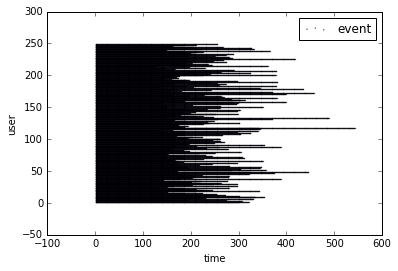

In [5]:
### DO PLOTS OF EVENT END TIME AND DATA POINTS
plt.scatter(dataset["time"],dataset["id"],0.1,label='event')
plt.xlabel('time')
plt.ylabel('user')
plt.legend()

In [19]:
### DO SIMPLE SPLIT BASED ON ID (COULD BE RANDOMIZED)
idmax = dataset["id"].max()
val_ratio = .2

dataset_train = dataset[dataset["id"]>=idmax*val_ratio]
dataset_test = dataset[dataset["id"]<idmax*val_ratio]

### GRAB data colnames
c =dataset.columns
data_col_names = [i for i in c if i not in ["id,time,event"]]

# train set
events_train  = tr.df_to_padded(df=dataset_train,column_names=['event'],t_col="time")
x_train       = tr.df_to_padded(df=dataset_train,column_names=(['event']+data_col_names),t_col="time")

# set set
events_test  =  tr.df_to_padded(df=dataset_test,column_names=['event'],t_col="time")
x_test       =  tr.df_to_padded(df=dataset_test,column_names=(['event']+data_col_names),t_col="time")


print("%i ids for training\n %i ids for testing" % (len(x_train),len(x_test)))
print(x_test.shape)
print(events_test.shape)

200 ids for training
 49 ids for testing
(49, 447, 30)
(49, 447, 1)


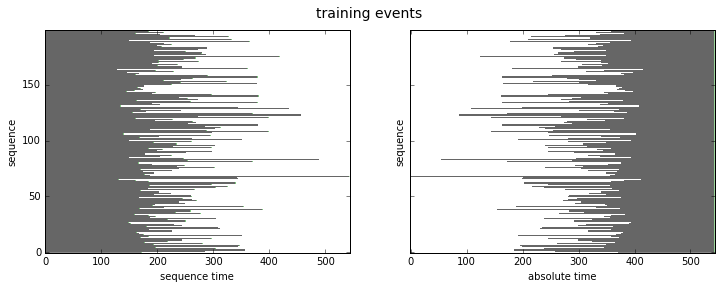

In [8]:
timeline_plot(np.squeeze(events_train),'training events',cmap='Accent_r');



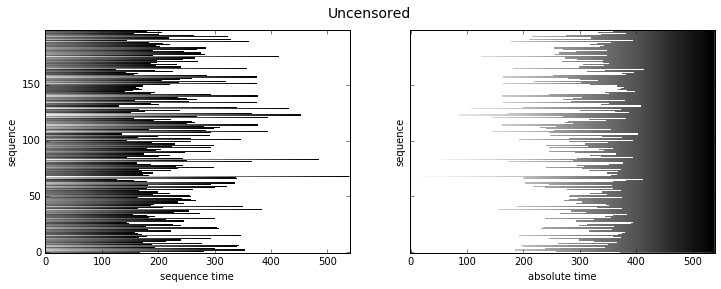

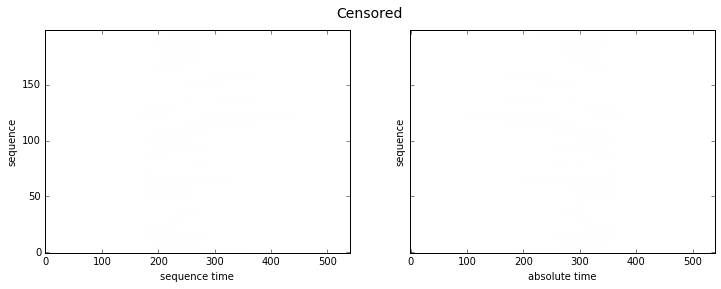

mean uncensored (train):  1.0
mean uncensored (test) :  1.0
mean tte (test):          134.233668342
max  tte (test):          442.0


In [29]:
def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.copy(np.concatenate([events,events],-1))
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*events
    return x,y,events
    
x_test,y_test,events_test   = prep_tensors(x_test,events_test)
x_train,y_train,events_train = prep_tensors(x_train,events_train)

timeline_plot(1-y_train[:,:,0],'Uncensored',cmap='Greys');
plt.show()
timeline_plot(1-y_train[:,:,1],'Censored',cmap='Greys');
plt.show()

print('mean uncensored (train): ',np.nanmean(y_train[:,:,1]))
print('mean uncensored (test) : ',np.nanmean(y_test[:,:,1]))
print('mean tte (test):         ',np.nanmean(y_test[:,:,0]))
print('max  tte (test):         ',np.nanmax(y_test[:,:,0]))



In [30]:
print(type(x_test))
print(type(y_test))
print(type(events_test))

print(x_test.shape)
print(y_test.shape)
print(events_test.shape)


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(49, 443, 30)
(49, 443, 2)
(49, 443, 1)


In [31]:
def nanmask_to_keras_mask(x,y,mask_value,tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.95
    sample_weights = (x[:,:,0]!=mask_value)*1.
    return x,y,sample_weights

tte_mean_train = np.nanmean(y_train[:,:,0])
mask_value = -1.3371337 
mean_u = np.nanmean(y_train[:,:,1])

x_test,y_test,sample_weights_test    = nanmask_to_keras_mask(x_test,y_test,mask_value,tte_mean_train)
x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train,y_train,mask_value,tte_mean_train)

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)


init_alpha:  131.858121434 mean uncensored train:  1.0


In [26]:
import keras.backend as K
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Masking
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras import callbacks

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=50, 
                                        verbose=0, 
                                        mode='auto', 
                                        epsilon=0.0001, 
                                        cooldown=0, 
                                        min_lr=1e-8)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False,per_epoch= True)
n_features = x_train.shape[-1]
        
def base_model():
    model = Sequential()
    model.add(Masking(mask_value=mask_value,input_shape=(None, n_features)))
    model.add(GRU(3,activation='tanh',return_sequences=True))
    return model
def wtte_rnn():
    model = base_model()

    model.add(TimeDistributed(Dense(2)))
    model.add(Lambda(wtte.output_lambda, 
                     arguments={"init_alpha":init_alpha, 
                                "max_beta_value":4.0,
                                "alpha_kernel_scalefactor":0.5}))

    loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function
    model.compile(loss=loss, optimizer=adam(lr=.01,clipvalue=0.5),sample_weight_mode='temporal')
    return model

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 30)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 3)           306       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 2)           8         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 2)           0         
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 49 samples
Epoch 1/100
200/200 [==============================] - 1s 6ms/step - loss: 5.9594 - val_loss: 5.9192
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 5.8905 - val_loss: 5.8982
Epoch 3/100
200/200 [========

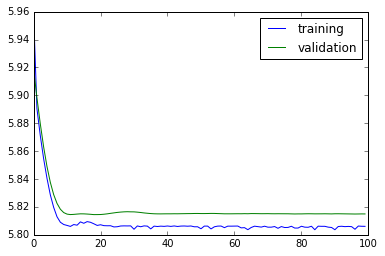

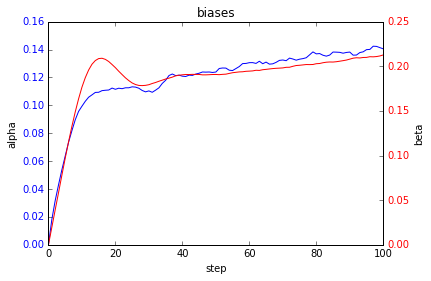

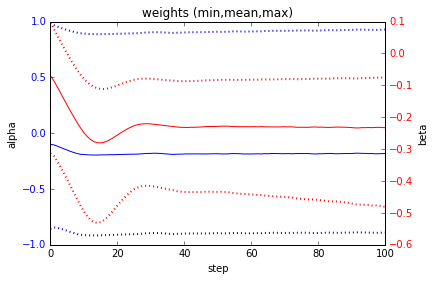

In [32]:
model = wtte_rnn()
model.summary()

K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train,
          epochs=100,
          batch_size=100, 
          verbose=1,
          validation_data=(x_test, y_test,sample_weights_test),
          sample_weight = sample_weights_train,
          callbacks=[nanterminator,history,weightwatcher,reduce_lr])

plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

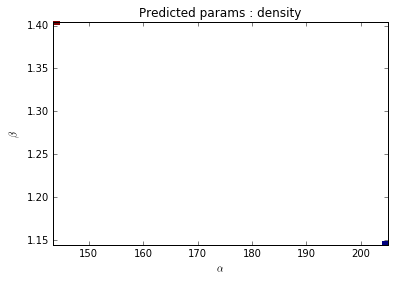

Bad Example?:


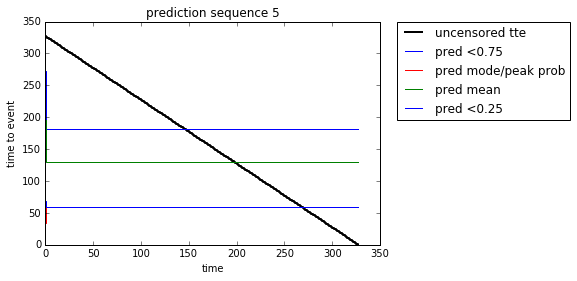

Good Example?:


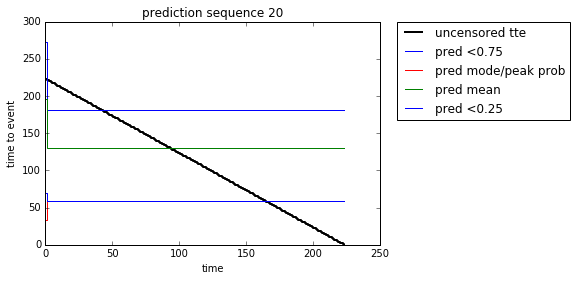

Good Example?:
alpha : mean    143.629402979
alpha : median  143.384872437
alpha :    min  143.384872437
alpha :    max  204.956665039
beta  : mean    1.4035272268
beta  : median  1.40455985069
beta  :    min  1.14454936981
beta  :    max  1.40455985069


In [33]:
# Optional: add a margin of zeros at the end of the sequence to see what the 
# model does after the first events (if it identifies death by pushing prediction to inf)

mask = np.copy(x_test)
mask[mask==mask_value] = np.nan
mask = mask*0
predicted = model.predict(x_test)+mask[:,:,:1]

alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

## log-alpha typically makes more sense.
from matplotlib.colors import LogNorm
counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
plt.title('Predicted params : density')
plt.xlim([alpha_flat.min(),alpha_flat.max()])
plt.ylim([beta_flat.min(),beta_flat.max()])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

# Pick out prediction for one sequence
batch_indx = 500
print('Bad Example?:')
for batch_indx in [5,20]:
    seq_len = (~np.isnan(predicted[batch_indx,:,0])).sum()
    a = predicted[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]
    b = predicted[batch_indx,:seq_len,1]+mask[batch_indx,:seq_len,0]
    t = np.array(xrange(len(a)))+mask[batch_indx,:seq_len,0]

    tte_actual   = y_test[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]

    ##### Prediction (Using weibull-quantities like quantiles etc)
    drawstyle = 'steps-post'
    plt.plot(t,tte_actual,label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)

    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
    plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)

    #     plt.ylim(0, 2*np.nanmax(tte_actual))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.title('prediction sequence '+str(batch_indx),)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print('Good Example?:')

print('alpha : mean   ',alpha_flat.mean())
print('alpha : median ',np.median(alpha_flat))
print('alpha :    min ',alpha_flat.min())
print('alpha :    max ',alpha_flat.max())
print('beta  : mean   ',beta_flat.mean())
print('beta  : median ',np.median(beta_flat))
print('beta  :    min ',beta_flat.min())
print('beta  :    max ',beta_flat.max())